# Monthly FSP Hydrology Regression (Inline Julia)

This notebook runs the deterministic single-well hydrology workflow using the monthly FSP injection format so we can compare Julia's pressure fields against the MATLAB monthly gold files.


## Prerequisites

1. Install Julia (1.9 or newer) and add the `IJulia` package so this notebook can run with a Julia kernel.
2. From the repository root, launch Jupyter Lab/Notebook via an environment that can start the Julia kernel.
3. Ensure the kernel's working directory is the repository root so that `regression_tests/gold` and the monthly injection CSV resolve.
4. Confirm that `regression_tests/1_well_julia_monthly_hydro_test.csv` (monthly injection format) and the `MonthlyInjectionReference*.csv` gold files are present before running this notebook.


In [33]:

# ============================================================================
# ENVIRONMENT SETUP
# ============================================================================
# Activate the FSP_3 Julia project environment and load all
# required packages

using Pkg
# Activate the FSP_3 project environment (contains all dependencies)
Pkg.activate(joinpath(pwd(), "FSP_3"))
# Install/update any missing packages specified in Project.toml
Pkg.instantiate()


using CSV           
using DataFrames    
using Dates         
using LinearAlgebra      
using Statistics        
using SpecialFunctions   # For expint (exponential integral) used in well pressure calculations

using Plots         # For creating plots and heatmaps


  Activating project at `c:\Users\bakirtzisn\Desktop\FSP_dev_test\FSP_3\regression_tests\FSP_3`


In [34]:

# ============================================================================
# HELPER FUNCTIONS
# ============================================================================
# These functions are copied from FSP_3 utilities and hydrology modules
# 

# Conversion constant: approximately 111.32 km per degree of latitude/longitude at the equator
#const KM_PER_DEG = 111.32
const KM_PER_DEG = 111.1951

# ----------------------------------------------------------------------------
# GRID CREATION FUNCTIONS
# ----------------------------------------------------------------------------

"""
    meshgrid(x, y)

Create 2D coordinate matrices from coordinate vectors (similar to MATLAB's meshgrid).
Used to create a grid of points for spatial calculations.

# Arguments
- x::Vector: x-coordinates (e.g., longitude values)
- y::Vector: y-coordinates (e.g., latitude values)

# Returns
- X::Matrix: Matrix where each row contains the x values
- Y::Matrix: Matrix where each column contains the y values
"""
function meshgrid(x::Vector{T}, y::Vector{S}) where {T,S}
    X = repeat(reshape(x, 1, :), length(y), 1)
    Y = repeat(reshape(y, :, 1), 1, length(x))
    return X, Y
end

"""
    create_spatial_grid_latlon(lat_min, lat_max, lon_min, lon_max; num_points=50)

Create the sparial grid in latitude/longitude coordinates for pressure field calculations.

# Arguments
- lat_min, lat_max: Latitude bounds (in degrees)
- lon_min, lon_max: Longitude bounds (in degrees)
- num_points: Number of grid points in each direction (default is 50)

# Returns
- lat_grid, lon_grid: 2D matrices of latitude and longitude coordinates
- lat_range, lon_range: 1D vectors of coordinate values
"""
function create_spatial_grid_latlon(lat_min::Float64, lat_max::Float64, lon_min::Float64, lon_max::Float64; num_points::Int=50)
    lat_range = collect(range(lat_min, stop=lat_max, length=num_points))
    lon_range = collect(range(lon_min, stop=lon_max, length=num_points))
    lon_grid, lat_grid = meshgrid(lon_range, lat_range)
    return lat_grid, lon_grid, lat_range, lon_range
end



"""
    md_to_m2(permeability_md)

Convert permeability from millidarcies (md) to square meters (m²).
# Conversion factor: 1 md = 9.869233e-16 m²
"""
md_to_m2(permeability_md) = permeability_md * 1.0e-3 * 9.9e-13



"""
    calcST(h_feet, phi, kap_md, rho, mu, g, beta, alphav)

Calculate aquifer Storativity (S) and Transmissivity (T).

# Arguments
- h_feet: Aquifer thickness (feet)
- phi: Porosity (0-1)
- kap_md: Permeability (millidarcies)
- rho: Fluid density (kg/m³)
- mu: Fluid viscosity (Pa·s)
- g: Gravitational acceleration (m/s²)
- beta: Fluid compressibility (1/Pa)
- alphav: Rock compressibility (1/Pa)

# Returns
- S: Storativity (dimensionless)
- T: Transmissivity (m²/s)
"""
function calcST(h_feet, phi, kap_md, rho, mu, g, beta, alphav)
    # Convert thickness from feet to meters
    h_meters = h_feet * 0.3048
    
    # Convert permeability to m²
    kap_m2 = md_to_m2(kap_md)
    
    # Storativity
    S = rho * g * h_meters * (alphav + phi * beta)
    
    # Hydraulic conductivity
    K = kap_m2 * rho * g / mu
    
    # Transmissivity
    T = K * h_meters
    
    return S, T
end

# ----------------------------------------------------------------------------
# DISTANCE CALCULATION
# ----------------------------------------------------------------------------

"""
    haversine_distance(lat1, lon1, lat2, lon2)

Calculate great-circle distance between two points using the Haversine formula.
This accounts for Earth's curvature and is accurate for distances up to ~1000 km.

# Arguments
- lat1, lon1: Coordinates of first point (degrees)
- lat2, lon2: Coordinates of second point (degrees)

# Returns
- Distance in kilometers
"""
haversine_distance(lat1, lon1, lat2, lon2) = begin
    R = 6371.0  # Earth's radius in km
    
    # lat/lon to radians conversion
    dlat = deg2rad(lat2 - lat1)
    dlon = deg2rad(lon2 - lon1)
    
    # Haversine formula
    a = sin(dlat / 2)^2 + cos(deg2rad(lat1)) * cos(deg2rad(lat2)) * sin(dlon / 2)^2
    c = 2 * atan(sqrt(a), sqrt(1 - a))
    
    return R * c
end

# ----------------------------------------------------------------------------
# PRESSURE FIELD CALCULATIONS
# ----------------------------------------------------------------------------

"""
    pressureScenario_Rall(bpds, days, r_meters, S, T, rho; evaluation_days_from_start)

Calculate pressure changes at multiple distances from an injection well using the Theis solution.
Implements superposition of multiple injection rate changes over time.

# Arguments
- bpds: Vector of injection rates at each time step (barrels per day)
- days: Vector of times when rate changes occur (days from start)
- r_meters: Vector of distances from well where pressure is calculated (meters)
- S: Storativity
- T: Transmissivity (m²/s)
- rho: Fluid density (kg/m³)
- evaluation_days_from_start: Time at which to evaluate pressure (optional)

# Returns
- Vector of pressure changes (psi) at each distance in r_meters
"""
function pressureScenario_Rall(bpds::Vector{Float64}, days::Vector{Float64}, r_meters::Vector{Float64}, S::Float64, T::Float64, rho::Float64; evaluation_days_from_start=nothing)
    # If the input vectors are empty, we can quit early and return zeros
    isempty(bpds) && return zeros(length(r_meters))
    isempty(days) && return zeros(length(r_meters))
    
    # Determine evaluation time (convert days to seconds)
    t_final_sec = isnothing(evaluation_days_from_start) ? maximum(days) * 86400.0 : evaluation_days_from_start * 86400.0
    
    # Convert injection rates from barrels/day to m³/s
    # 1 barrel = 0.159 m³, 1 day = 86400 seconds
    Q_m3s = bpds .* 1.84013e-6
    
    n = length(bpds)
    head_accum = zeros(length(r_meters))  # Accumulated hydraulic head changes
    prev_Q = 0.0  # Tracks previous flow rate for rate changes
    
    # Loop through each rate change and apply superposition
    for i in 1:n
        t_i_sec = days[i] * 86400.0  # Time of this rate change
        dt = t_final_sec - t_i_sec   # Time elapsed since this rate change
        dt <= 0 && continue  # Skip future rate changes
        
        # Calculate the change in flow rate (for superposition)
        dQ = Q_m3s[i] - prev_Q
        prev_Q = Q_m3s[i]
        dQ == 0 && continue  # if we don't have a rate change, we can skip this iteration
        
        # Calculate dimensionless parameter u for Theis solution
        u = (r_meters .^ 2 .* S) ./ (4.0 * T * dt)
        
        # well function W(u) using exponential integral
        well_func = expint.(u)
        
        # Accumulate head contribution from this rate change
        head_accum .+= well_func .* dQ
    end
    
    # Convert accumulated head to pressure
    head_m = head_accum ./ (4pi * T)  # Hydraulic head in meters
    dp_pascals = head_m .* (rho * 9.81)  # Convert to pressure (Pascals)
    dp_psi = dp_pascals ./ 6894.76  # Convert to psi
    
    # Clean up non-finite values and ensure non-negative pressures
    dp_psi[.!isfinite.(dp_psi)] .= 0.0
    dp_psi = max.(0.0, dp_psi)
    
    return dp_psi
end

"""
    pfieldcalc_all_rates(lat_grid, lon_grid, S, T, rho, days, rates, well_lon, well_lat; evaluation_days_from_start)

Calculate the 2D pressure field across a spatial grid for a single injection well.
This is the main function that combines distance calculations with pressure modeling.

# Arguments
- `lat_grid, lon_grid`: 2D matrices of latitude/longitude coordinates
- `S, T, rho`: Aquifer properties (storativity, transmissivity, fluid density)
- `days`: Vector of times when injection rates change
- `rates`: Vector of injection rates (barrels per day)
- `well_lon, well_lat`: Well location coordinates
- `evaluation_days_from_start`: Time at which to evaluate the pressure field

# Returns
- 2D matrix of pressure changes (psi) at each grid point
"""
function pfieldcalc_all_rates(lat_grid::Array{Float64,2}, lon_grid::Array{Float64,2}, S::Float64, T::Float64, rho::Float64,
                              days::Vector{Float64}, rates::Vector{Float64}, well_lon::Float64, well_lat::Float64; evaluation_days_from_start=nothing)
    # Calculate distance from each grid point to the well using Haversine formula
    dist_km = haversine_distance.(lat_grid, lon_grid, well_lat, well_lon)
    
    # Flatten to 1D vector and convert km to meters
    dist_m = vec(dist_km .* 1000.0)
    
    # Calculate pressure at each distance using Theis solution
    pressures = pressureScenario_Rall(rates, days, dist_m, S, T, rho; evaluation_days_from_start=evaluation_days_from_start)
    
    # Reshape back to 2D grid matching input dimensions
    return reshape(pressures, size(lat_grid))
end

# ----------------------------------------------------------------------------
# INJECTION SCHEDULE PREPARATION
# ----------------------------------------------------------------------------

"""
    prepare_monthly_fsp_data(well_data, start_year, inj_start_date, end_year, inj_end_date, 
                             year_of_interest, extrapolate, yoi_date)

Convert monthly injection data into step-function format (times and rates) for pressure calculations.
This processes monthly injection volumes and converts them to daily rates, tracking rate changes.

# Arguments
- `well_data`: DataFrame with columns Year, Month, InjectionRate (monthly volume in barrels)
- `start_year, end_year`: Range of injection activity
- `inj_start_date, inj_end_date`: Date range for injection
- `year_of_interest`: Year for which we're calculating pressure
- `extrapolate`: If true, continue last rate beyond data; if false, set to zero
- `yoi_date`: Date at which to evaluate pressure (typically Dec 31 of year_of_interest)

# Returns
- `step_times`: Vector of days (from start) when rate changes occur
- `step_rates`: Vector of injection rates (barrels per day) at each time
"""
function prepare_monthly_fsp_data(well_data::DataFrame, start_year::Int, inj_start_date::Date,
                                  end_year::Int, inj_end_date::Date, year_of_interest::Int,
                                  extrapolate::Bool, yoi_date::Date)
    # If injection starts after evaluation date, return empty
    if start_year > year(yoi_date)
        return Float64[], Float64[]
    end
    
    global_start_date = inj_start_date
    global_end_date = min(inj_end_date, yoi_date)
    
    step_times = Float64[]  # Days from start when rate changes
    step_rates = Float64[]  # Injection rates (bbl/day) at each change
    current_rate = 0.0      # Track current rate to detect changes
    current_date = global_start_date
    
    # Iterate through each month in the date range
    while current_date <= global_end_date
        y = year(current_date)
        m = month(current_date)
        
        # Find data for this month
        month_rows = well_data[(well_data.Year .== y) .& (well_data.Month .== m), :]
        
        if nrow(month_rows) > 0
            # Convert monthly volume to daily rate
            monthly_vol = month_rows[1, "InjectionRate"]
            daily_rate = monthly_vol / Dates.daysinmonth(current_date)
            
            # Only record if rate changed (avoid redundant entries)
            if abs(daily_rate - current_rate) > 1e-6
                push!(step_times, Float64((current_date - global_start_date).value + 1))
                push!(step_rates, daily_rate)
                current_rate = daily_rate
            end
        elseif !extrapolate && current_rate > 0
            # No data for this month and not extrapolating: set rate to zero
            push!(step_times, Float64((current_date - global_start_date).value + 1))
            push!(step_rates, 0.0)
            current_rate = 0.0
        end
        
        current_date = current_date + Dates.Month(1)
    end
    
    # Add final rate at end date if still injecting
    if current_rate > 0
        push!(step_times, Float64((global_end_date - global_start_date).value + 1))
        push!(step_rates, extrapolate ? current_rate : 0.0)
    end
    
    return step_times, step_rates
end

"""
    prepare_well_data_for_pressure_scenario(df, well_id, start_year, inj_start_date, 
                                            end_year, inj_end_date, data_type, 
                                            year_of_interest, extrapolate, yoi_date)

Wrapper function to prepare well injection data for pressure calculations.
Currently only supports "monthly_fsp" format.

# Arguments
- `df`: DataFrame containing well injection data
- `well_id`: String identifier for the well
- Other arguments: See prepare_monthly_fsp_data

# Returns
- `step_times, step_rates`: Vectors for use in pressure calculations
"""
function prepare_well_data_for_pressure_scenario(df::DataFrame, well_id::AbstractString,
    start_year::Int, inj_start_date::Date, end_year::Int, inj_end_date::Date, data_type::String,
    year_of_interest::Int, extrapolate::Bool, yoi_date::Date)
    # Only monthly FSP format is implemented in this notebook
    data_type == "monthly_fsp" || error("This notebook helper only implements the monthly FSP format")
    
    # Filter to specific well - convert both to strings for comparison
    well_rows = df[string.(df.WellID) .== well_id, :]
    
    return prepare_monthly_fsp_data(well_rows, start_year, inj_start_date, end_year, inj_end_date, year_of_interest, extrapolate, yoi_date)
end


prepare_well_data_for_pressure_scenario

In [35]:
# ============================================================================
# LOAD MATLAB REFERENCE DATA (MONTHLY GOLD)
# ============================================================================
using CSV, DataFrames

const NOTEBOOK_DIR = @__DIR__
const GOLD_DIR     = joinpath(NOTEBOOK_DIR, "gold")
const MONTHLY_GOLD_PREFIX = "MonthlyInjectionReference"

function load_monthly_surfaces(years::Vector{Int})
    frames = DataFrame[]

    for year in years
        path = joinpath(GOLD_DIR, "$(MONTHLY_GOLD_PREFIX)$(year).csv")
        if !isfile(path)
            @warn "File not found: $path"
            continue
        end

        lines = readlines(path)
        if length(lines) < 3
            @warn "File $path seems incomplete (less than 3 lines)"
            continue
        end

        data_lines = filter(!isempty, lines[3:end])
        if isempty(data_lines)
            @warn "File $path does not contain any data rows"
            continue
        end

        clean_header = "X_Easting_km,Y_Northing_km,additionalPressure_PSI"
        clean_io = IOBuffer(join([clean_header; data_lines], "
"))

        df = CSV.read(clean_io, DataFrame)
        df.Year = fill(year, nrow(df))
        push!(frames, df)
    end

    if isempty(frames)
        @warn "No monthly gold surfaces were loaded for years = $years"
        return DataFrame()
    end

    combined = vcat(frames...)
    sort!(combined, [:Year, :Y_Northing_km, :X_Easting_km])
    return combined
end

years_to_test = [2021, 2022, 2023, 2024]
gold_df = load_monthly_surfaces(years_to_test)
first(gold_df, 5)


Row,X_Easting_km,Y_Northing_km,additionalPressure_PSI,Year
,Float64,Float64,Float64,Int64
1,-7.668,-7.283,0.094546,2021
2,-7.3415,-7.283,0.11686,2021
3,-7.0149,-7.283,0.1433,2021
4,-6.6884,-7.283,0.17434,2021
5,-6.3619,-7.283,0.21041,2021


In [36]:
# ============================================================================
# DEFINE MONTHLY INJECTION SCENARIO
# ============================================================================
const MONTHLY_INJECTION_FILE = joinpath(NOTEBOOK_DIR, "1_well_julia_monthly_hydro_test.csv")

monthly_injection_df = CSV.read(MONTHLY_INJECTION_FILE, DataFrame)
if "InjectionRate(bbl/month)" in names(monthly_injection_df)
    rename!(monthly_injection_df, "InjectionRate(bbl/month)" => "InjectionRate")
end

years_in_data = sort(unique(monthly_injection_df.Year))
start_year = first(years_in_data)
end_year = last(years_in_data)
well_id = string(first(monthly_injection_df.WellID))

scenario = Dict(
    :aquifer => Dict(
        :thickness_ft => 100.0,
        :porosity => 0.10,
        :permeability_md => 200.0
    ),
    :fluid => Dict(
        :density => 1000.0,
        :viscosity => 0.0008,
        :compressibility => 3.6e-10,
        :gravity => 9.81
    ),
    :rock => Dict(
        :compressibility => 1.08e-9
    ),
    :grid => Dict(
        :x_min_km => -7.668,
        :x_max_km => 8.332,
        :y_min_km => -7.283,
        :y_max_km => 8.717,
        :npts => 50
    ),
    :injection => Dict(
        :well_id => well_id,
        :data_type => "monthly_fsp",
        :start_year => start_year,
        :end_year => end_year,
        :extrapolate => false,
        :well_x_km => 0.0,
        :well_y_km => 0.0,
        :source_file => MONTHLY_INJECTION_FILE
    )
)

scenario[:injection][:well_lat] = scenario[:injection][:well_y_km] / KM_PER_DEG
scenario[:injection][:well_lon] = scenario[:injection][:well_x_km] / KM_PER_DEG

injection_df = monthly_injection_df

println("Loaded $(nrow(injection_df)) monthly rows for well $(scenario[:injection][:well_id]) (years $start_year-$end_year)")
first(injection_df, 5)


Loaded 60 monthly rows for well 3 (years 2020-2024)


Row,WellID,Latitude(WGS84),Longitude(WGS84),Year,Month,InjectionRate
,Int64,Float64,Float64,Int64,Int64,Float64
1,3,29.0691,-97.8499,2020,1,600000.0
2,3,29.0691,-97.8499,2020,2,600000.0
3,3,29.0691,-97.8499,2020,3,500000.0
4,3,29.0691,-97.8499,2020,4,400000.0
5,3,29.0691,-97.8499,2020,5,300000.0


In [37]:
# ============================================================================
# RUN JULIA HYDROLOGY MODEL (MONTHLY INJECTION)
# ============================================================================
function grid_from_df(df::DataFrame, value_col::Symbol)
    df = sort(df, [:Year, :Latitude, :Longitude])
    grids = Dict{Int, Matrix{Float64}}()

    for group in groupby(df, :Year)
        year = group.Year[1]
        lat_vals = unique(group.Latitude)
        lon_vals = unique(group.Longitude)
        pivot = reshape(group[!, value_col], length(lat_vals), length(lon_vals))
        grids[year] = pivot
    end

    return grids
end

lat_min = scenario[:grid][:y_min_km] / KM_PER_DEG
lat_max = scenario[:grid][:y_max_km] / KM_PER_DEG
lon_min = scenario[:grid][:x_min_km] / KM_PER_DEG
lon_max = scenario[:grid][:x_max_km] / KM_PER_DEG
lat_grid, lon_grid, _, _ = create_spatial_grid_latlon(lat_min, lat_max, lon_min, lon_max; num_points=scenario[:grid][:npts])

S, T = calcST(
    scenario[:aquifer][:thickness_ft],
    scenario[:aquifer][:porosity],
    scenario[:aquifer][:permeability_md],
    scenario[:fluid][:density],
    scenario[:fluid][:viscosity],
    scenario[:fluid][:gravity],
    scenario[:fluid][:compressibility],
    scenario[:rock][:compressibility]
)
rho = scenario[:fluid][:density]

function run_year(year::Int, lat_grid, lon_grid, scenario, injection_df, S, T, rho)
    inj = scenario[:injection]
    inj_start_year = inj[:start_year]
    inj_end_year = inj[:end_year]
    inj_start_date = Date(inj_start_year, 1, 1)
    inj_end_date = Date(inj_end_year, 12, 31)
    yoi_date = Date(year - 1, 12, 31)
    actual_end_year = min(inj_end_year, year)

    days, rates = prepare_well_data_for_pressure_scenario(
        injection_df,
        inj[:well_id],
        inj_start_year,
        inj_start_date,
        actual_end_year,
        inj_end_date,
        inj[:data_type],
        year,
        inj[:extrapolate],
        yoi_date
    )

    isempty(days) && return DataFrame()

    eval_days = Float64((yoi_date - inj_start_date).value + 1)

    # Compute 2D pressure field using Theis solution with superposition
    pfield = pfieldcalc_all_rates(
        lat_grid, lon_grid, S, T, rho, days, rates, 
        inj[:well_lon], inj[:well_lat]; 
        evaluation_days_from_start=eval_days
    )

    df = DataFrame(
        Year = fill(year, length(pfield)),
        Latitude = vec(lat_grid),
        Longitude = vec(lon_grid),
        Pressure_psi = vec(pfield)
    )

    return df
end

fsp_results = DataFrame()
for year in years_to_test
    println("Computing pressure field for year $year...")
    yearly = run_year(year, lat_grid, lon_grid, scenario, injection_df, S, T, rho)
    fsp_results = isempty(fsp_results) ? yearly : vcat(fsp_results, yearly)
end

println("Julia monthly model complete. Total rows: $(nrow(fsp_results))")
first(fsp_results, 5)


Computing pressure field for year 2021...
Computing pressure field for year 2022...
Computing pressure field for year 2023...
Computing pressure field for year 2024...
Julia monthly model complete. Total rows: 10000


Row,Year,Latitude,Longitude,Pressure_psi
,Int64,Float64,Float64,Float64
1,2021,-0.0654975,-0.0689599,0.186566
2,2021,-0.0625609,-0.0689599,0.22695
3,2021,-0.0596244,-0.0689599,0.273881
4,2021,-0.0566878,-0.0689599,0.327872
5,2021,-0.0537513,-0.0689599,0.389343


In [38]:
# ============================================================================
# COMPUTE REGRESSION METRICS
# ============================================================================
gold_df[:, :Latitude] = gold_df[:, :Y_Northing_km] / KM_PER_DEG
gold_df[:, :Longitude] = gold_df[:, :X_Easting_km] / KM_PER_DEG

gold_grids = grid_from_df(
    gold_df[:, [:Year, :Latitude, :Longitude, :additionalPressure_PSI]],
    :additionalPressure_PSI
)
fsp_grids = grid_from_df(
    fsp_results[:, [:Year, :Latitude, :Longitude, :Pressure_psi]],
    :Pressure_psi
)

metrics = DataFrame(
    Year=Int[],
    RMSE=Float64[],
    MaxAbs=Float64[],
    MedianAbs=Float64[]
)

for year in years_to_test
    haskey(gold_grids, year) && haskey(fsp_grids, year) || continue

    gold_grid = gold_grids[year]
    fsp_grid = fsp_grids[year]
    diff = fsp_grid .- gold_grid

    push!(metrics, (
        year,
        sqrt(mean(diff .^ 2)),
        maximum(abs.(diff)),
        median(abs.(diff))
    ))
end

println("Regression Metrics (Julia monthly vs MATLAB monthly):")
println("Lower values indicate better agreement")
metrics


Regression Metrics (Julia monthly vs MATLAB monthly):
Lower values indicate better agreement


Row,Year,RMSE,MaxAbs,MedianAbs
,Int64,Float64,Float64,Float64
1,2021,19.9804,287.288,1.27662
2,2022,47.748,640.262,5.95161
3,2023,77.3068,994.902,14.2139
4,2024,107.843,1350.08,24.6838


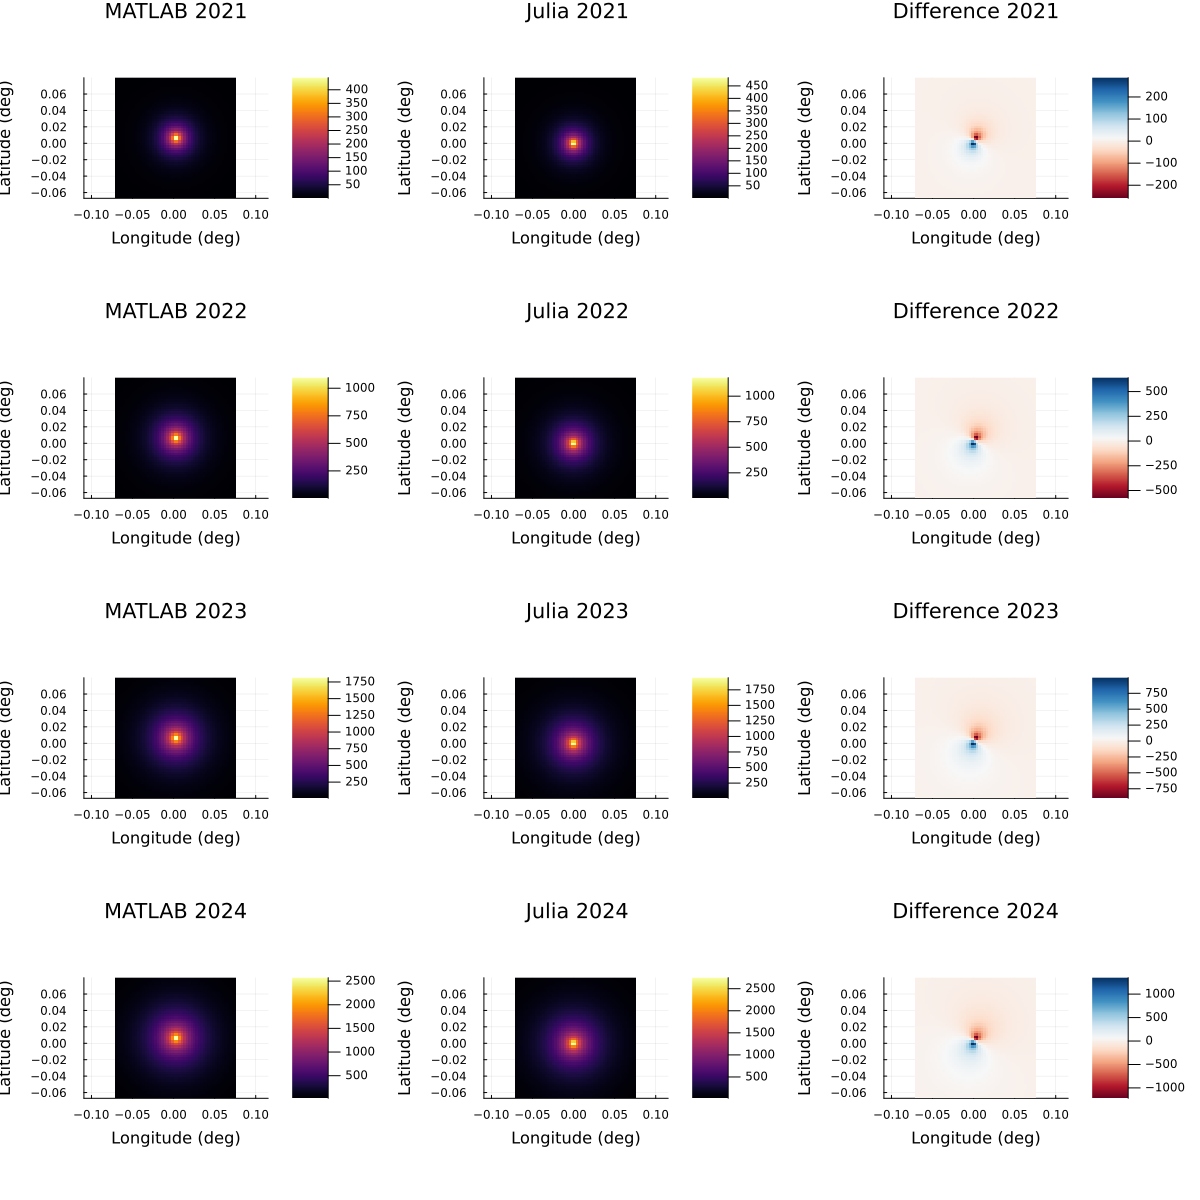

In [39]:
# ============================================================================
# VISUAL COMPARISON: HEATMAPS
# ============================================================================
plot_titles = ["MATLAB", "Julia", "Difference"]
plots = []

# Create coordinate ranges for heatmap axes
lon_range = range(lon_min, lon_max, length=scenario[:grid][:npts])
lat_range = range(lat_min, lat_max, length=scenario[:grid][:npts])

for year in years_to_test
    haskey(gold_grids, year) && haskey(fsp_grids, year) || continue

    gold_grid = gold_grids[year]
    fsp_grid = fsp_grids[year]
    diff_grid = fsp_grid .- gold_grid

    push!(plots, heatmap(
        lon_range, lat_range, gold_grid,
        title="$(plot_titles[1]) $(year)",
        aspect_ratio=1,
        xlabel="Longitude (deg)",
        ylabel="Latitude (deg)"
    ))

    push!(plots, heatmap(
        lon_range, lat_range, fsp_grid,
        title="$(plot_titles[2]) $(year)",
        aspect_ratio=1,
        xlabel="Longitude (deg)",
        ylabel="Latitude (deg)"
    ))

    push!(plots, heatmap(
        lon_range, lat_range, diff_grid,
        title="$(plot_titles[3]) $(year)",
        aspect_ratio=1,
        cbar=true,
        color=:RdBu,
        xlabel="Longitude (deg)",
        ylabel="Latitude (deg)"
    ))
end

plot(
    plots...,
    layout=(length(years_to_test), 3),
    size=(1200, 300 * length(years_to_test))
)


In [40]:
# ============================================================================
# SUMMARY AND NEXT STEPS
# ============================================================================

## What This Notebook Does

1. Loads the MATLAB monthly gold pressure surfaces for years 2021-2024.
2. Reads the monthly FSP injection file `1_well_julia_monthly_hydro_test.csv` and converts it into step-wise rates.
3. Computes the Theis pressure fields for the matching grid and years.
4. Reports RMSE/max/median differences between MATLAB and Julia results.
5. Visualizes the pressure fields and their differences across the grid.

## Next Steps

- Automate the regression by turning the metric table into CI assertions.
- Extend to multi-well monthly datasets once they become available.
- If needed, adapt the grid bounds or injection base point to align with other regional datasets.


Base.Meta.ParseError: ParseError:
# Error @ c:\Users\bakirtzisn\Desktop\FSP_dev_test\FSP_3\regression_tests\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_X12sZmlsZQ==.jl:7:3

1. Loads the MATLAB monthly gold pressure surfaces for years 2021-2024.
# └───────────────────────────────────────────────────────────────────┘ ── extra tokens after end of expression

# ============================================================================
# SUMMARY
# ============================================================================

## What This Notebook Does

This notebook performs a **regression test** of the Julia FSP hydrology model against MATLAB reference data:

1. **Loads MATLAB reference data** ("gold standard") - pressure fields for years 2021-2024
2. **Defines a test scenario** - single injection well with specified aquifer properties and monthly injection format
3. **Runs Julia hydrology model** - calculates pressure fields using Theis solution with monthly rate variations
4. **Compares results** - computes RMSE, max error, and median error metrics
5. **Visualizes differences** - creates side-by-side heatmaps

## How to Interpret Results

- **RMSE < 0.1 psi**: Excellent agreement
- **Max error < 1 psi**: Good agreement
